# PS Injection Bump using CPYMAD

TODO:
- [ ] Load lattice files
- [ ] Use flags for selection - merge with pyORBIT simulation parameters flags
- [ ] Check start of lattice, tunes etc
- [ ] Implement all macros etc
- [ ] Save initial PTC twiss (?) for initial beam distribution matching
- [ ] Convert to .py and run
- [ ] Add necessary includes to virtual environment (pip install cpymad, tfs)
- [ ] Move scripts to PyORBIT simulation script

#### Regular imports

In [28]:
import os
import numpy as np
import pandas as pnd

import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.gridspec as gridspec
from matplotlib.patches import Patch, Rectangle

### Import MADX from CPYMAD

**cpymad is a Cython binding to MAD-X for giving full control and access to a MAD-X interpreter in python.**
https://pypi.org/project/cpymad/

Installed (on linux) like:

`pip install cpymad`  or  `pip3 install cpymad`

In [29]:
from cpymad.madx import Madx

# Python 3 version of the metaclass by the OMC team: pip install tfs-pandas
import tfs

#### Standard matplotlib plot parameters

In [30]:
plt.rcParams['figure.figsize'] = [8.0, 5.0]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 100

plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 14

plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10

plt.rcParams['font.size'] = 10
plt.rcParams['legend.fontsize'] = 8

plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams['lines.markersize'] = 5

#### Functions

In [31]:
def make_directory(path):
    if os.path.isdir(path):
        print ("Directory %s already exists" % path)  
    else:
        try:
            os.mkdir(path)
        except OSError:
            print ("Creation of the directory %s failed" % path)
        else:
            print ("Successfully created the directory %s" % path)  

In [32]:
def calculate_beta_rel(gamma):
        return np.sqrt(1-1/gamma**2)

Test Alex Huschauer's plotting function and modify as required. Taken from https://gitlab.cern.ch/acc-models/acc-models-ps/-/blob/2021/_scripts/web/webtools.py

In [33]:
def plot_lattice_elements(ax, twiss_in, suppress_x=False):
    # Adapted from Alex Huschauer's (CERN ABP) webtools found at:
    # https://gitlab.cern.ch/acc-models/acc-models-ps/-/tree/2021/_scripts/web
    
    # Set plot limits
    ax.set_ylim(-1.5,1.5)
    
    # Suppress ticks on y-axis
    #ax.set_yticks([])
    #ax.set_yticklabels([])
    ax.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
        
    if suppress_x:
        ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        #ax.set_xticks([])
        #ax.set_xticklabels([])

    # Extract Twiss Header
    twiss = tfs.read(twiss_in)
    twissHeader = dict(twiss.headers)
    print(twissHeader['SEQUENCE'])
    # Positions and lengths of elements
    pos = twiss.S.values - twiss.L.values/2
    lengths = twiss.L.values
    total_length = (pos[-1]+lengths[-1])
    print('Full length of accelerator lattice = ', total_length, 'm')
    
    # modify lengths in order to plot zero-length elements
    lengths[np.where(lengths == 0)[0]] += 0.001
    
    # Plot line through centre
    ax.plot([0, total_length], [0., 0.], color='k', linestyle='-', linewidth=1)
    
    # Markers - black 0.1m centred lines    
    idx = np.array([idx for idx, elem in enumerate(twiss.KEYWORD.values) if 'MARKER' in elem])
    for i in idx:
        ax.add_patch(Rectangle((pos[i], -0.5), width = 0.1, height = 1., angle=0.0, ec='k', fc='k', lw=0.0))
    
    # BENDS - red centred rectangles   
    idx = np.array([idx for idx, elem in enumerate(twiss.KEYWORD.values) if 'BEND' in elem])
    for i in idx:
        ax.add_patch(Rectangle((pos[i], -0.5), width = lengths[i], height = 1., angle=0.0, ec='k', fc='r', lw=0.0))
    
    # Kickers - cyan centred rectangles 
    idx = np.array([idx for idx, elem in enumerate(twiss.KEYWORD.values) if 'HKICKER' in elem])
    for i in idx:
        ax.add_patch(Rectangle((pos[i], -0.5), width = lengths[i], height = 1., angle=0.0, ec='k', fc='c', lw=0.0))
    idx = np.array([idx for idx, elem in enumerate(twiss.KEYWORD.values) if 'VKICKER' in elem])       
    for i in idx:
        ax.add_patch(Rectangle((pos[i], -0.5), width = lengths[i], height = 1., angle=0.0, ec='k', fc='c', lw=0.0))
              
    # QUADRUPOLES - blue offset rectangles indicatinf Focussing or Defocussing
    idx = np.array([idx for idx, elem in enumerate(twiss.KEYWORD.values) if 'QUADRUPOLE' in elem])
    name = np.array(twiss.NAME.values)[idx]
    if (twissHeader['SEQUENCE'] == 'SYNCHROTRON'):
        idx_1 = idx[np.array([i for i, n in enumerate(name) if 'QD' in n])]
        idx_2 = idx[np.array([i for i, n in enumerate(name) if 'QF' in n])]
    offset = [-0.5, 0.5]
    for i in idx_1:
        ax.add_patch(Rectangle((pos[i], (-0.5 + offset[0])), width = lengths[i], height = 1., angle=0.0, ec='k', fc='b', lw=0.0))
    for i in idx_2:
        ax.add_patch(Rectangle((pos[i], (-0.5 + offset[1])), width = lengths[i], height = 1., angle=0.0, ec='k', fc='b', lw=0.0))
    

#### Create Plot folder

In [34]:
save_folder = 'cpymad_plots/'
make_directory(save_folder)
#legend_label = 'Case'
main_label = 'PS'

Directory Plots/ already exists


## Flags

In [ ]:
LIU = False
BCMS = True
start_with_marker = False
match_tunes = True
match_chroma = False

### Check contents of support files

In [36]:
madx_0 = Madx()
madx_0.option(echo=True)

madx_0.call(file='PS_Lattice/ps_mu.seq')          # Main sequence
if BCMS:
    madx_0.call(file='PS_Lattice/ps_ss_h9.seq')   # BCMS Harmonic 9
else:
    madx_0.call(file='PS_Lattice/ps_ss_h7.seq')   # Standard Harmonic 7

madx_0.call(file='PS_Lattice/ps.str')             # Strength file
madx_0.call(file='PS_Lattice/macros.ptc')         # User defined macros
madx_0.call(file='PS_Lattice/tunes.str')          # Tunes and initial position


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.03.30 10:51:21      +
  ++++++++++++++++++++++++++++++++++++++++++++
//lat3ud file in madx format



//basic lattice below.



kqtd = .00610063;    // nominal numbers for 4.31 and 3.83 lattice

kqtf = -.01155444;



! Amplitude and Harmonic for QTD

a1:=0.000;

b1:=0.000;

hn1:=7;



! Amplitude and Harmonic for QTF

a2:=0.000;

b2:=0.000;

hn2:=8;



HER0qtd:=(a1*cos(hn1*(0/10)*2*PI))+(b1*sin(hn1*(0/10)*2*PI));

HER1qtd:=(a1*cos(hn1*(1/10)*2*PI))+(b1*sin(hn1*(1/10)*2*PI));

HER2qtd:=(a1*cos(hn1*(2/10)*2*PI))+(b1*sin(hn1*(2/10)*2*PI));

HER3qtd:=(a1*cos(hn1*(3/10)*2*PI))+(b1*sin(hn1*(3/10)*2*PI));

HER4qtd:=(a1*cos(hn1*(4/10)*2*PI))+(b1*sin(hn1*(4/10)*2*PI));

HER5qtd:=(a1*cos(hn1*(5/10)*2*PI))+(b1*sin(hn1*(5/10)*2*PI));

HER6qtd:=(a1*cos(hn1*(6/10)*2*PI))+(b1*sin(hn1*(6/10)*

In [ ]:
if LIU:
    madx.input('beam, particle=proton, pc=2.7844;')
else:
    madx.input('beam, particle=proton, pc=2.14;')
    
madx.input('BRHO      := BEAM->PC * 3.3356;')
    

### Set lattice start position

In [ ]:
lattice_start ='''
seqedit,sequence = PS;
	flatten;
endedit;

seqedit,sequence = PS;
	call, file = 'PS_Lattice/remove_elements.seq';
	remove, element=SELECTED;
endedit;

IF(lattice_start==0){
seqedit, sequence=PS;
	flatten;
	cycle , start=PR.BWSV64;
	flatten;
endedit;
}
ELSE{
seqedit, sequence=PS;
	flatten;
	cycle , start=PR.BWSH65;
	flatten;
endedit;
}
'''
madx.input(lattice_start)

Use this if PTC doesn't find a closed solution - replace MONITOR with MARKER

In [1]:
use_start_lattice_marker='''
IF(start_lattice_marker==1){
	START_LATTICE: MARKER;

	seqedit,sequence = PS;
		flatten;
		!REPLACE, ELEMENT=PR.BWSH65, BY=START_LATTICE;
		!REPLACE, ELEMENT=PR.BWSV64, BY=START_LATTICE;
		REPLACE, ELEMENT=lattice_start, BY=START_LATTICE;
		cycle , start = START_LATTICE;
	endedit;
}
'''
if start_with_marker:
    madx.input(use_start_lattice_marker)    

NameError: name 'start_with_marker' is not defined

In [ ]:
bare_machine_PTC_twiss=
'''
! PTC integration parameters

propagation_method = 2; 
order_of_integrator = 6;

! propagation_method 1: Drift-Kick-Drift
! 2 = 2nd order, one kick per integration step, naive.
! 4 = Ruth-Neri-Yoshida 4th order method, 3 kicks per integration step.
! 6 = Yoshida 6th order method, 7 kicks per integration step.

! propagation_method 2: Matrix-Kick-Matrix
! 2 = Euler-like Matrix-Kick-Matrix
! 4 = Simpson-like (1/6)K-M-(2/3)K-M-(1/6)K
! 6 = Bode-like (7/90)K-M-(32/90)K-M-(12/90)K-M-(32/90)K-M-(7/90)K

! exact = true ensures SBENDs orbit is correct
! avoids quadrupole feed-down effects leading to closed orbit distortions
exact_flag = true;

! time=true: every derivative wrt dp/p needs to be multiplied by the relativistic beta DQ1, DISP1,...) required for flat file generation!
! time=false: forget about beta and take the value as it is - use for PTC_Twiss 
time_flag = false;

integration_steps_per_element = 5; ! 3;
map_order = 5;

! Only call this once or ther errors are erased
use, sequence=PS;

ptc_create_universe;
ptc_create_layout, time=false, model=propagation_method, method=order_of_integrator, nst=integration_steps_per_element, exact=true;
select, flag=ptc_twiss, clear; 
select, flag=ptc_twiss, column=name, s, betx, bety, disp1, disp3, x, px, y, py;
ptc_twiss, icase=5, no=map_order, closed_orbit, file=optimised_bare_simplified.tfs, table=ptc_twiss;
ptc_end;
'''

madx.input(bare_machine_PTC_twiss)    

In [ ]:
matchtunes = '''
EXEC, match_Tunes(use_pfw, tune_x, tune_y);
value, tune_x, tune_y, Qxp, Qyp; 
'''
if match_tunes:
    madx.input(matchtunes)    

In [ ]:
matchchroma = '''
EXEC, match_Chroma_PFW(Qxp, Qyp, Qxp2, Qyp2);
value, tune_x, tune_y, Qxp, Qyp; 
'''
if match_chroma:
    madx.input(matchchroma)

In [37]:
madx_1 = Madx()
madx_1.option(echo=True)

madx_1.call(file='ISIS_Lattice/lattice.ele')
madx_1.call(file='ISIS_Lattice/synchrotron.seq')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.03.30 10:51:23      +
  ++++++++++++++++++++++++++++++++++++++++++++
//lat3ud file in madx format



//basic lattice below.



kqtd = .00610063;    // nominal numbers for 4.31 and 3.83 lattice

kqtf = -.01155444;



! Amplitude and Harmonic for QTD

a1:=0.000;

b1:=0.000;

hn1:=7;



! Amplitude and Harmonic for QTF

a2:=0.000;

b2:=0.000;

hn2:=8;



HER0qtd:=(a1*cos(hn1*(0/10)*2*PI))+(b1*sin(hn1*(0/10)*2*PI));

HER1qtd:=(a1*cos(hn1*(1/10)*2*PI))+(b1*sin(hn1*(1/10)*2*PI));

HER2qtd:=(a1*cos(hn1*(2/10)*2*PI))+(b1*sin(hn1*(2/10)*2*PI));

HER3qtd:=(a1*cos(hn1*(3/10)*2*PI))+(b1*sin(hn1*(3/10)*2*PI));

HER4qtd:=(a1*cos(hn1*(4/10)*2*PI))+(b1*sin(hn1*(4/10)*2*PI));

HER5qtd:=(a1*cos(hn1*(5/10)*2*PI))+(b1*sin(hn1*(5/10)*2*PI));

HER6qtd:=(a1*cos(hn1*(6/10)*2*PI))+(b1*sin(hn1*(6/10)*

In [38]:
madx_2 = Madx()
madx_2.option(echo=True)

madx_2.call(file='ISIS_Lattice/injection.beam')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.03.30 10:51:23      +
  ++++++++++++++++++++++++++++++++++++++++++++
beam, particle = proton, energy = (0.070440002 + 0.938);



## Run whole script

In [39]:
madx = Madx()
madx.option(echo=False)
madx.input('beam, particle = proton, energy = (0.070440002 + 0.938);')
madx.call(file='ISIS_Lattice/run_injection.madx')      


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.03.30 10:51:25      +
  ++++++++++++++++++++++++++++++++++++++++++++
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: spnum redefined
++++++ info: seqedit - number of elements installed:  70
++++++ info: seqedit - number of elements moved:      0
++++++ info: seqedit - number of elements removed:   

In [40]:
madx.input('USE, SEQUENCE=synchrotron;')

True

## MAD-X Twiss

In [41]:
madx.input('SELECT,flag=TWISS,COLUMN=keyword, name, s, betx, alfx, mux, bety, alfy, muy, x, px, y, py, t, pt, dx, dpx, dy, dpy, wx, phix, dmux, wy, phiy, dmuy, ddx, ddpx, ddy, ddpy, r11, r12, r21, r22, energy, l, angle, k0l, k0sl, k1l, k1sl, k2l, k2sl, k3l, k3sl, k4l, k4sl, k5l, k5sl, k6l, k6sl, k7l, k7sl, k8l, k8sl, k9l, k9sl, k10l, k10sl, ksi, hkick, vkick, tilt, e1, e2, h1, h2, hgap, fint, fintx, volt, lag, freq, harmon, slot_id, assembly_id, mech_sep, kmax, kmin, calib, polarity, alfa, beta11, beta12, beta13, beta21, beta22, beta23, beta31, beta32, beta33, alfa11, alfa12, alfa13, alfa21, alfa22, disp1, disp2, disp3, disp4')
#madx.input('SELECT,flag=TWISS;')
madx_twiss = madx.twiss(sequence='synchrotron', file='isis_twiss.tfs')

enter Twiss module

++++++ table: summ

            length             orbit5               alfa            gammatr 
         163.36282                 -0      0.03891361506         5.06931421 

                q1                dq1            betxmax              dxmax 
        4.31010672       -13.03611904        17.81314431        8.862969298 

             dxrms             xcomax             xcorms                 q2 
        5.38665793                  0                  0        3.829998069 

               dq2            betymax              dymax              dyrms 
      -13.37807111        16.62817033                  0                  0 

            ycomax             ycorms             deltap            synch_1 
                 0                  0                  0                  0 

           synch_2            synch_3            synch_4            synch_5 
                 0                  0                  0                  0 

           synch_6            

## PTC Twiss

In [42]:
madx.input('ptc_create_universe')
madx.input('ptc_create_layout, time=false,model=2, method=6, nst=5, exact=true')
madx.input('ptc_twiss, closed_orbit, icase=56, no=4, slice_magnets')
madx.input('ptc_end')


++++++ table: ptc_twiss_summary

            length            alpha_c          alpha_c_p         alpha_c_p2 
         163.36282      0.03891361505       0.4113725823       -3.073815983 

        alpha_c_p3              eta_c           gamma_tr                 q1 
       30.92927977      -0.8267665462         5.06931421       0.3101067202 

                q2                dq1                dq2                 qs 
      0.8299980692       -4.777694743       -4.903019055                  0 

        beta_x_min         beta_x_max         beta_y_min         beta_y_max 
       2.145653693        18.01663837        3.995364885        16.76508009 

         beta11min          beta11max          beta12min          beta12max 
       2.145653693        18.01663837                  0                  0 

         beta13min          beta13max          beta21min          beta21max 
                 0                  0                  0                  0 

         beta22min          beta22ma

True

In [43]:
ptc_twiss_summary = madx.table['ptc_twiss_summary']
for k in ptc_twiss_summary.keys():
    if ptc_twiss_summary[k][0] > 0:
        print(k + ' = ' + str(ptc_twiss_summary[k][0]))

length = 163.36281999999764
alpha_c = 0.03891361505492863
alpha_c_p = 0.4113725823388982
alpha_c_p3 = 30.929279773792445
gamma_tr = 5.069314209679108
q1 = 0.31010672015028995
q2 = 0.829998069157744
beta_x_min = 2.145653693097721
beta_x_max = 18.016638365443647
beta_y_min = 3.9953648849730206
beta_y_max = 16.765080086070597
beta11min = 2.145653693097721
beta11max = 18.016638365443647
beta22min = 3.9953648849730206
beta22max = 16.765080086070597
disp1max = 3.2539588866724203
disp2max = 1.072902931392462
orbit_x = 1.4774756745618788e-13
orbit_px = 2.771691258740786e-14
xcorms = 8.832311264049368e-14
pxcorms = 3.3909234383156504e-14
tcorms = 8.705397140154536e-14
xcomax = 1.7053025658242404e-13
pxcomax = 5.6001669125433015e-14
tcomax = 3.0808688933348094e-15
pxcomin = 1.9738898803021375e-15


In [44]:
ptc_twiss = madx.table['ptc_twiss']
list(ptc_twiss)

['name',
 'keyword',
 's',
 'betx',
 'alfx',
 'mux',
 'bety',
 'alfy',
 'muy',
 'x',
 'px',
 'y',
 'py',
 't',
 'pt',
 'dx',
 'dpx',
 'dy',
 'dpy',
 'wx',
 'phix',
 'dmux',
 'wy',
 'phiy',
 'dmuy',
 'ddx',
 'ddpx',
 'ddy',
 'ddpy',
 'r11',
 'r12',
 'r21',
 'r22',
 'energy',
 'l',
 'angle',
 'k0l',
 'k0sl',
 'k1l',
 'k1sl',
 'k2l',
 'k2sl',
 'k3l',
 'k3sl',
 'k4l',
 'k4sl',
 'k5l',
 'k5sl',
 'k6l',
 'k6sl',
 'k7l',
 'k7sl',
 'k8l',
 'k8sl',
 'k9l',
 'k9sl',
 'k10l',
 'k10sl',
 'k11l',
 'k11sl',
 'k12l',
 'k12sl',
 'k13l',
 'k13sl',
 'k14l',
 'k14sl',
 'k15l',
 'k15sl',
 'k16l',
 'k16sl',
 'k17l',
 'k17sl',
 'k18l',
 'k18sl',
 'k19l',
 'k19sl',
 'k20l',
 'k20sl',
 'ksi',
 'hkick',
 'vkick',
 'tilt',
 'e1',
 'e2',
 'h1',
 'h2',
 'hgap',
 'fint',
 'fintx',
 'volt',
 'lag',
 'freq',
 'harmon',
 'slot_id',
 'assembly_id',
 'mech_sep',
 'v_pos',
 'bbcharge',
 'xma',
 'yma',
 'sigx',
 'sigy',
 'lrad',
 'parent',
 'comments',
 're11',
 're12',
 're13',
 're14',
 're15',
 're16',
 're21',
 're22

#### the twiss object now contains the full TFS table information for each element in the lattice
The keywords available are:

In [45]:
list(madx_twiss)

['name',
 'keyword',
 's',
 'betx',
 'alfx',
 'mux',
 'bety',
 'alfy',
 'muy',
 'x',
 'px',
 'y',
 'py',
 't',
 'pt',
 'dx',
 'dpx',
 'dy',
 'dpy',
 'wx',
 'phix',
 'dmux',
 'wy',
 'phiy',
 'dmuy',
 'ddx',
 'ddpx',
 'ddy',
 'ddpy',
 'r11',
 'r12',
 'r21',
 'r22',
 'energy',
 'l',
 'angle',
 'k0l',
 'k0sl',
 'k1l',
 'k1sl',
 'k2l',
 'k2sl',
 'k3l',
 'k3sl',
 'k4l',
 'k4sl',
 'k5l',
 'k5sl',
 'k6l',
 'k6sl',
 'k7l',
 'k7sl',
 'k8l',
 'k8sl',
 'k9l',
 'k9sl',
 'k10l',
 'k10sl',
 'k11l',
 'k11sl',
 'k12l',
 'k12sl',
 'k13l',
 'k13sl',
 'k14l',
 'k14sl',
 'k15l',
 'k15sl',
 'k16l',
 'k16sl',
 'k17l',
 'k17sl',
 'k18l',
 'k18sl',
 'k19l',
 'k19sl',
 'k20l',
 'k20sl',
 'ksi',
 'hkick',
 'vkick',
 'tilt',
 'e1',
 'e2',
 'h1',
 'h2',
 'hgap',
 'fint',
 'fintx',
 'volt',
 'lag',
 'freq',
 'harmon',
 'slot_id',
 'assembly_id',
 'mech_sep',
 'v_pos',
 'bbcharge',
 'xma',
 'yma',
 'sigx',
 'sigy',
 'lrad',
 'parent',
 'comments',
 're11',
 're12',
 're13',
 're14',
 're15',
 're16',
 're21',
 're22

In [46]:
list(ptc_twiss)

['name',
 'keyword',
 's',
 'betx',
 'alfx',
 'mux',
 'bety',
 'alfy',
 'muy',
 'x',
 'px',
 'y',
 'py',
 't',
 'pt',
 'dx',
 'dpx',
 'dy',
 'dpy',
 'wx',
 'phix',
 'dmux',
 'wy',
 'phiy',
 'dmuy',
 'ddx',
 'ddpx',
 'ddy',
 'ddpy',
 'r11',
 'r12',
 'r21',
 'r22',
 'energy',
 'l',
 'angle',
 'k0l',
 'k0sl',
 'k1l',
 'k1sl',
 'k2l',
 'k2sl',
 'k3l',
 'k3sl',
 'k4l',
 'k4sl',
 'k5l',
 'k5sl',
 'k6l',
 'k6sl',
 'k7l',
 'k7sl',
 'k8l',
 'k8sl',
 'k9l',
 'k9sl',
 'k10l',
 'k10sl',
 'k11l',
 'k11sl',
 'k12l',
 'k12sl',
 'k13l',
 'k13sl',
 'k14l',
 'k14sl',
 'k15l',
 'k15sl',
 'k16l',
 'k16sl',
 'k17l',
 'k17sl',
 'k18l',
 'k18sl',
 'k19l',
 'k19sl',
 'k20l',
 'k20sl',
 'ksi',
 'hkick',
 'vkick',
 'tilt',
 'e1',
 'e2',
 'h1',
 'h2',
 'hgap',
 'fint',
 'fintx',
 'volt',
 'lag',
 'freq',
 'harmon',
 'slot_id',
 'assembly_id',
 'mech_sep',
 'v_pos',
 'bbcharge',
 'xma',
 'yma',
 'sigx',
 'sigy',
 'lrad',
 'parent',
 'comments',
 're11',
 're12',
 're13',
 're14',
 're15',
 're16',
 're21',
 're22

### Check output PTC Twiss TFS table to read relativistic gamma for plot normalisation

In [47]:
ptc_twiss_file = 'isis_twiss.tfs'

ptc_twiss_read = tfs.read(ptc_twiss_file)
ptc_twiss_read_Header = dict(ptc_twiss_read.headers)

In [48]:
gamma_rel = ptc_twiss_read_Header['GAMMA']
beta_rel = calculate_beta_rel(gamma_rel)
p_mass_GeV = 0.93827208816 #Proton mass GeV
tot_energy = gamma_rel * p_mass_GeV
kin_energy = tot_energy - p_mass_GeV
momentum = ptc_twiss_read_Header['PC']

print('Relativistic Gamma = ', round(gamma_rel,3))
print('Relativistic Beta = ', round(beta_rel,3))
print('Total Energy = ', round(tot_energy,4), 'GeV')
print('Kinetic Energy = ', round(kin_energy*1E3,3), 'MeV')
print('momentum = ', round(momentum,3), 'GeV/c')

Relativistic Gamma =  1.075
Relativistic Beta =  0.366
Total Energy =  1.0084 GeV
Kinetic Energy =  70.168 MeV
momentum =  0.37 GeV/c


### Now we can plot the TWISS

SYNCHROTRON
Full length of accelerator lattice =  163.36282 m


<ipython-input-49-5bd5a69d037d>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()


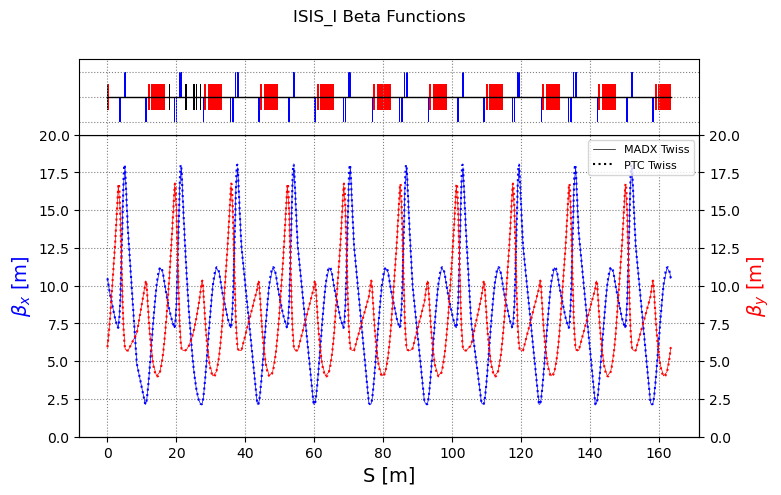

In [49]:
case_label = 'Beta Functions'

fig1 = plt.figure(facecolor='w', edgecolor='k')
gs = fig1.add_gridspec(ncols=1,nrows=2, height_ratios=[1,4])
gs.update(wspace=0.025, hspace=0.)

ax1 = fig1.add_subplot(gs[1,0])
ax2 = ax1.twinx()
ax3 = fig1.add_subplot(gs[0,0], sharex=ax1)

tit = main_label+ ' ' + case_label
#ax1.set_title(tit);
fig1.suptitle(tit);

plot_lattice_elements(ax3,'isis_twiss.tfs',suppress_x=True)

ax1.plot(madx_twiss.s, madx_twiss.betx, color='b', lw=0.5)
ax1.plot(ptc_twiss.s, ptc_twiss.betx, color='b', ls=':')
ax2.plot(madx_twiss.s, madx_twiss.bety, color='r', lw=0.5)
ax2.plot(ptc_twiss.s, ptc_twiss.bety, color='r', ls=':')

ax1.set_xlabel('S [m]')
ax1.set_ylabel(r'$\beta_x$ [m]', color='b')
ax2.set_ylabel(r'$\beta_y$ [m]', color='r')

ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='major', ls=':', color='grey')

ax1.set_ylim(0,20)
ax2.set_ylim(0,20)


legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]

ax1.legend(handles=legend_elements, loc=1)

fig1.tight_layout()

savename = save_folder + 'ISIS_I_Beta_Functions.png'
plt.savefig(savename)

SYNCHROTRON
Full length of accelerator lattice =  163.36282 m


<ipython-input-50-ed305e2571a9>:38: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()


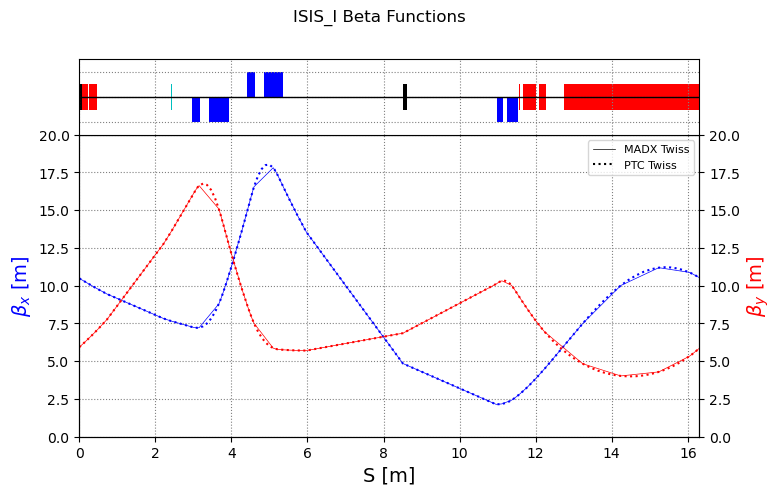

In [50]:
case_label = 'Beta Functions'

fig1 = plt.figure(facecolor='w', edgecolor='k')
gs = fig1.add_gridspec(ncols=1,nrows=2, height_ratios=[1,4])
gs.update(wspace=0.025, hspace=0.)

ax1 = fig1.add_subplot(gs[1,0])
ax2 = ax1.twinx()
ax3 = fig1.add_subplot(gs[0,0], sharex=ax1)

tit = main_label+ ' ' + case_label
#ax1.set_title(tit);
fig1.suptitle(tit);

plot_lattice_elements(ax3,'isis_twiss.tfs',suppress_x=True)

ax1.plot(madx_twiss.s, madx_twiss.betx, color='b', lw=0.5)
ax1.plot(ptc_twiss.s, ptc_twiss.betx, color='b', ls=':')
ax2.plot(madx_twiss.s, madx_twiss.bety, color='r', lw=0.5)
ax2.plot(ptc_twiss.s, ptc_twiss.bety, color='r', ls=':')

ax1.set_xlabel('S [m]')
ax1.set_ylabel(r'$\beta_x$ [m]', color='b')
ax2.set_ylabel(r'$\beta_y$ [m]', color='r')

ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='major', ls=':', color='grey')

ax1.set_ylim(0,20)
ax2.set_ylim(0,20)
ax1.set_xlim(0,16.3)


legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]

ax1.legend(handles=legend_elements, loc=1)

fig1.tight_layout()

savename = save_folder + 'ISIS_I_Beta_Functions_zoom.png'
plt.savefig(savename)

SYNCHROTRON
Full length of accelerator lattice =  163.36282 m


<ipython-input-51-d192048f5923>:35: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()


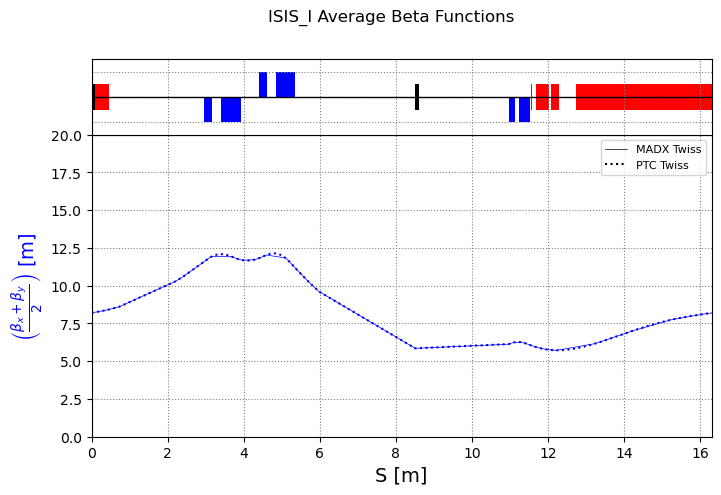

In [51]:
case_label = 'Average Beta Functions'

fig1 = plt.figure(facecolor='w', edgecolor='k')
gs = fig1.add_gridspec(ncols=1,nrows=2, height_ratios=[1,4])
gs.update(wspace=0.025, hspace=0.)

ax1 = fig1.add_subplot(gs[1,0])
#ax2 = ax1.twinx()
ax3 = fig1.add_subplot(gs[0,0], sharex=ax1)

tit = main_label+ ' ' + case_label
plot_lattice_elements(ax3,'isis_twiss.tfs',suppress_x=True)

#ax1.set_title(tit);
fig1.suptitle(tit);
ax1.plot(madx_twiss.s, (madx_twiss.betx+madx_twiss.bety)/2, color='b', lw=0.5)
ax1.plot(ptc_twiss.s, (ptc_twiss.betx+ptc_twiss.bety)/2, color='b', ls=':')

ax1.set_xlabel('S [m]')
ax1.set_ylabel(r'$\left(\frac{\beta_x + \beta_y}{2}\right)$ [m]', color='b')
#ax2.set_ylabel(r'$\beta_y$ [m]', color='r')

ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='major', ls=':', color='grey')

ax1.set_ylim(0,20)
#ax2.set_ylim(0,20)
ax1.set_xlim(0,16.3)


legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]

ax1.legend(handles=legend_elements, loc=1)

fig1.tight_layout()

savename = save_folder + 'ISIS_I_Average_Beta_Functions_zoom.png'
plt.savefig(savename)

SYNCHROTRON
Full length of accelerator lattice =  163.36282 m


<ipython-input-52-b0e5d15363e6>:37: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()


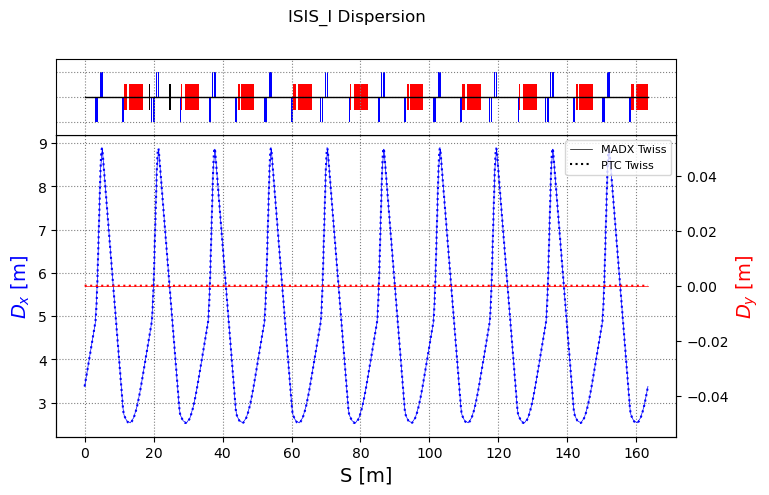

In [52]:
case_label = 'Dispersion'

fig1 = plt.figure(facecolor='w', edgecolor='k')
gs = fig1.add_gridspec(ncols=1,nrows=2, height_ratios=[1,4])
gs.update(wspace=0.025, hspace=0.)

ax1 = fig1.add_subplot(gs[1,0])
ax2 = ax1.twinx()
ax3 = fig1.add_subplot(gs[0,0], sharex=ax1)

tit = main_label+ ' ' + case_label
plot_lattice_elements(ax3,'isis_twiss.tfs',suppress_x=True)

#ax1.set_title(tit);
fig1.suptitle(tit);
ax1.plot(madx_twiss.s, madx_twiss.dx, color='b', lw=0.5)
ax1.plot(ptc_twiss.s, ptc_twiss.disp1/beta_rel, color='b', ls=':')
ax2.plot(madx_twiss.s, madx_twiss.dy, color='r', lw=0.5)
ax2.plot(ptc_twiss.s, ptc_twiss.disp3/beta_rel, color='r', ls=':')

ax1.set_xlabel('S [m]')
ax1.set_ylabel(r'$D_x$ [m]', color='b')
ax2.set_ylabel(r'$D_y$ [m]', color='r')

ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='major', ls=':', color='grey')

#ax1.set_ylim(0,20)
#ax2.set_ylim(0,20)
#ax1.set_xlim(0,16.3)


legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]

ax1.legend(handles=legend_elements, loc=1)

fig1.tight_layout()

savename = save_folder + 'ISIS_I_Dispersion.png'
plt.savefig(savename)

SYNCHROTRON
Full length of accelerator lattice =  163.36282 m


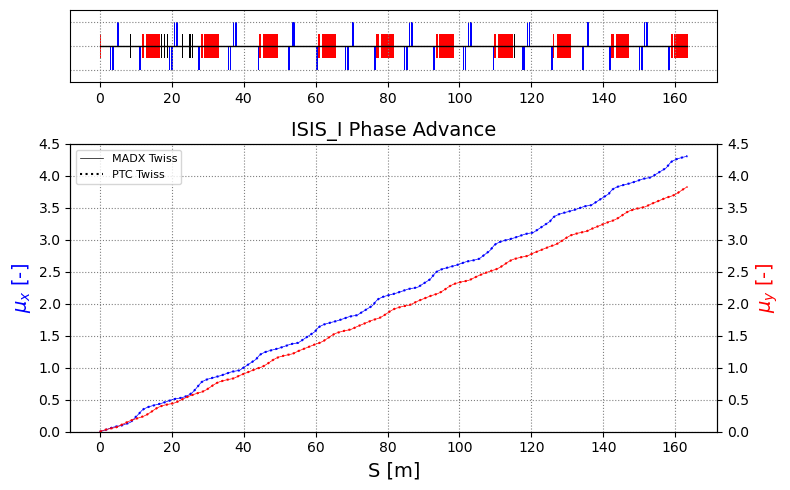

In [62]:
case_label = 'Phase Advance'

fig1 = plt.figure(facecolor='w', edgecolor='k')
gs = fig1.add_gridspec(ncols=1,nrows=2, height_ratios=[1,4])

ax1 = fig1.add_subplot(gs[1,0])
ax2 = ax1.twinx()
ax3 = fig1.add_subplot(gs[0,0], sharex=ax1)

tit = main_label+ ' ' + case_label
plot_lattice_elements(ax3,'isis_twiss.tfs')

ax1.set_title(tit);
ax1.plot(madx_twiss.s, madx_twiss.mux, color='b', lw=0.5)
ax1.plot(ptc_twiss.s, ptc_twiss.mu1, color='b', ls=':')
ax2.plot(madx_twiss.s, madx_twiss.muy, color='r', lw=0.5)
ax2.plot(ptc_twiss.s, ptc_twiss.mu2, color='r', ls=':')

ax1.set_xlabel('S [m]')
ax1.set_ylabel(r'$\mu_x$ [-]', color='b')
ax2.set_ylabel(r'$\mu_y$ [-]', color='r')

ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='major', ls=':', color='grey')

ax1.set_ylim(0,4.5)
ax2.set_ylim(0,4.5)
#ax1.set_xlim(0,16.3)


legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]

ax1.legend(handles=legend_elements, loc=2)

fig1.tight_layout()

savename = save_folder + 'ISIS_I_Phase_Advance_zoom.png'
plt.savefig(savename)

SYNCHROTRON
Full length of accelerator lattice =  163.36282 m


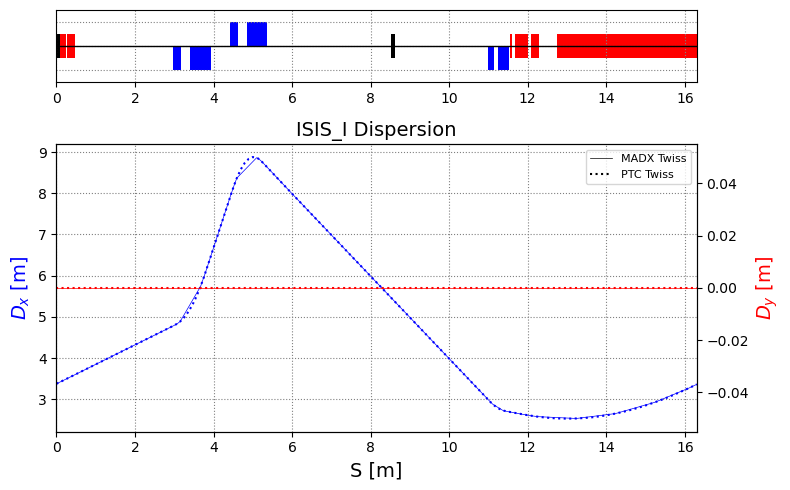

In [53]:
case_label = 'Dispersion'

fig1 = plt.figure(facecolor='w', edgecolor='k')
gs = fig1.add_gridspec(ncols=1,nrows=2, height_ratios=[1,4])

ax1 = fig1.add_subplot(gs[1,0])
ax2 = ax1.twinx()
ax3 = fig1.add_subplot(gs[0,0], sharex=ax1)

tit = main_label+ ' ' + case_label
plot_lattice_elements(ax3,'isis_twiss.tfs')

ax1.set_title(tit);
ax1.plot(madx_twiss.s, madx_twiss.dx, color='b', lw=0.5)
ax1.plot(ptc_twiss.s, ptc_twiss.disp1/beta_rel, color='b', ls=':')
ax2.plot(madx_twiss.s, madx_twiss.dy, color='r', lw=0.5)
ax2.plot(ptc_twiss.s, ptc_twiss.disp3/beta_rel, color='r', ls=':')

ax1.set_xlabel('S [m]')
ax1.set_ylabel(r'$D_x$ [m]', color='b')
ax2.set_ylabel(r'$D_y$ [m]', color='r')

ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='major', ls=':', color='grey')

#ax1.set_ylim(0,20)
#ax2.set_ylim(0,20)
ax1.set_xlim(0,16.3)


legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]

ax1.legend(handles=legend_elements, loc=1)

fig1.tight_layout()

savename = save_folder + 'ISIS_I_Dispersion_zoom.png'
plt.savefig(savename)

SYNCHROTRON
Full length of accelerator lattice =  163.36282 m


<ipython-input-54-508214e979cc>:51: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig1.tight_layout()


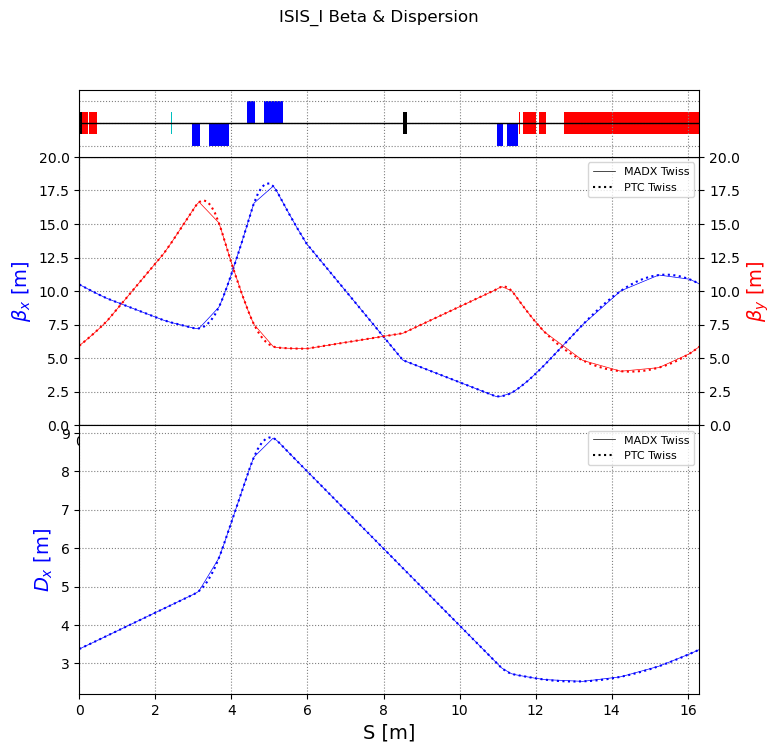

In [54]:
case_label = 'Beta & Dispersion'

# Make Figure and gridspec for multiplot layout control
fig1 = plt.figure(facecolor='w', edgecolor='k', figsize=[8.0, 8.0])
gs = fig1.add_gridspec(ncols=1,nrows=3, height_ratios=[1,4,4])
gs.update(wspace=0.025, hspace=0.)

ax1 = fig1.add_subplot(gs[1,0])
ax2 = ax1.twinx()
ax3 = fig1.add_subplot(gs[0,0], sharex=ax1)
ax4 = fig1.add_subplot(gs[2,0], sharex=ax1)

tit = main_label+ ' ' + case_label
fig1.suptitle(tit);

# Function to add accelerator block diagram
plot_lattice_elements(ax3,'isis_twiss.tfs', suppress_x=True)

# Plots from PTC/MADX Twiss
ax1.plot(madx_twiss.s, madx_twiss.betx, color='b', lw=0.5)
ax1.plot(ptc_twiss.s, ptc_twiss.betx, color='b', ls=':')
ax2.plot(madx_twiss.s, madx_twiss.bety, color='r', lw=0.5)
ax2.plot(ptc_twiss.s, ptc_twiss.bety, color='r', ls=':')
ax4.plot(madx_twiss.s, madx_twiss.dx, color='b', lw=0.5)
ax4.plot(ptc_twiss.s, ptc_twiss.disp1/beta_rel, color='b', ls=':')

ax1.set_xlabel('S [m]')
ax1.set_ylabel(r'$\beta_x$ [m]', color='b')
ax2.set_ylabel(r'$\beta_y$ [m]', color='r')
ax4.set_xlabel('S [m]')
ax4.set_ylabel(r'$D_x$ [m]', color='b')

# Suppress middle plot x ticks and labels
ax1.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')        

# Add grids
ax1.grid(which='both', ls=':', color='grey')
ax3.grid(which='major', ls=':', color='grey')
ax4.grid(which='both', ls=':', color='grey')

ax1.set_ylim(0,20)
ax2.set_ylim(0,20)
ax1.set_xlim(0,16.3)

# Custom legend
legend_elements = [Line2D([0], [0], color='k', lw=0.5, label='MADX Twiss'), Line2D([0], [0], color='k', ls=':', label='PTC Twiss')]
ax1.legend(handles=legend_elements, loc=1)
ax4.legend(handles=legend_elements, loc=1)

# Save
fig1.tight_layout()
savename = save_folder + 'ISIS_I_Beta_Dispersion_zoom.png'
plt.savefig(savename)

## Plot machine survey

In [56]:
madx.input('survey;')
mySurvey=madx.table.survey.dframe()

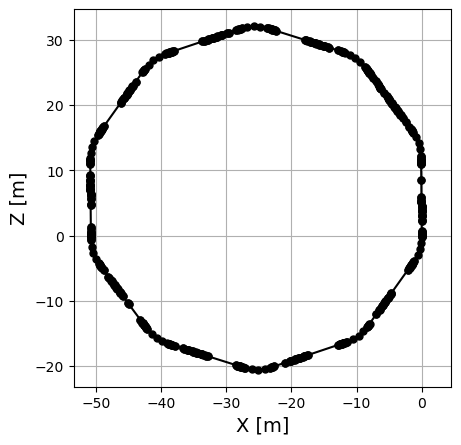

In [57]:
plt.plot(mySurvey.x,mySurvey.z,'o-k')
plt.axis('square');
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()

In [ ]:
qfSurvey=mySurvey[mySurvey['name'].str.contains('qf')]
qdSurvey=mySurvey[mySurvey['name'].str.contains('qd')]
mbSurvey=mySurvey[mySurvey['name'].str.contains('mb')]

plt.plot(qfSurvey.x,qfSurvey.z,'ob')
plt.plot(qdSurvey.x,qdSurvey.z,'or')
plt.plot(mbSurvey.x,mbSurvey.z,'.k')

plt.axis('square');
plt.xlabel('X [m]')
plt.ylabel('Z [m]')
plt.grid()